## Prepare Data

In [1]:
!mkdir -p dog
!cp /phfs/datasets/dog/* /project/phusers/sab/dog
!mkdir -p dog_json
!cp /phfs/datasets/dog_json/* /project/phusers/sab/dog_json
print('prepare data done!')

prepare data done!


## Start Training
After labeled all the images, you can run the following cells to start training and log results to MLflow.

In [2]:
import json
import shutil
import os
from pathlib import Path

In [3]:
dir_path = './dog_json'
data_path = './data'
data_train_chihuahua_path = os.path.join(data_path, 'train', 'chihuahua')
data_train_shihtzu_path = os.path.join(data_path, 'train', 'shihtzu')
data_val_chihuahua_path = os.path.join(data_path, 'val', 'chihuahua')
data_val_shihtzu_path = os.path.join(data_path, 'val', 'shihtzu')

p = Path(dir_path).glob('**/*')
files = [x for x in p if x.is_file()]

shutil.rmtree(data_path, ignore_errors=True)
os.makedirs(data_train_chihuahua_path, exist_ok=True)
os.makedirs(data_train_shihtzu_path, exist_ok=True)
os.makedirs(data_val_chihuahua_path, exist_ok=True)
os.makedirs(data_val_shihtzu_path, exist_ok=True)

val_count = 4
val_chihuahua_count = 0
val_shihtzu_count = 0

for file in files:
    f = open(file)
    data = json.load(f)
    file_path = '/' + data['task']['data']['image'].split('?d=')[-1]
    file_name = file_path.split('/')[-1]
    result = data['result'][0]['value']['choices'][0]
    if result == 'chihuahua':
        if val_chihuahua_count < val_count:
            shutil.copyfile(file_path, os.path.join(data_val_chihuahua_path, file_name))
            val_chihuahua_count = val_chihuahua_count + 1
        else:
            shutil.copyfile(file_path, os.path.join(data_train_chihuahua_path, file_name))
    else:
        if val_shihtzu_count < val_count:
            shutil.copyfile(file_path, os.path.join(data_val_shihtzu_path, file_name))
            val_shihtzu_count = val_shihtzu_count + 1
        else:
            shutil.copyfile(file_path, os.path.join(data_train_shihtzu_path, file_name))
    f.close()
    
print('done')

done


In [4]:
!pip install tensorflow_hub

  Using cached tensorflow_hub-0.12.0-py2.py3-none-any.whl (108 kB)


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing import image_dataset_from_directory

import mlflow
mlflow.set_experiment("dog_train")
mlflow.tensorflow.autolog()

2023/01/10 05:33:39 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


In [6]:
PATH = './data'

In [7]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')

In [8]:
BATCH_SIZE = 8
IMG_SIZE = (1024, 1024)

In [9]:
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 12 files belonging to 2 classes.


2023-01-10 05:33:50.200083: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-10 05:33:50.223393: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-10 05:33:50.225916: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-10 05:33:50.229068: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [10]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 8 files belonging to 2 classes.


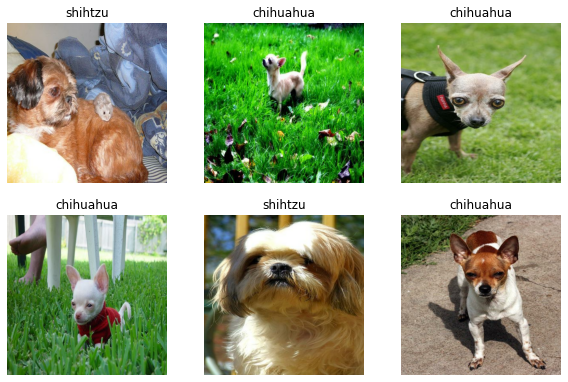

In [11]:
class_names = train_dataset.class_names

show_img = 1

if show_img:
    plt.figure(figsize=(10, 10))
    for images, labels in train_dataset.take(1):
        for i in range(6):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

In [12]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip(),
])

In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [14]:
model_url = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5"
base_model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(224, 224),
    hub.KerasLayer(model_url, trainable=False)
])
base_model.build([None, 224, 224, 3])

In [15]:
base_model.trainable = False

In [16]:
prediction_layer = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(l2=0.1))

In [17]:
inputs = tf.keras.Input(shape=(1024, 1024, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [18]:
base_learning_rate = 0.01

In [19]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr=base_learning_rate, momentum=0.9),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024, 1024, 3)]   0         
                                                                 
 sequential (Sequential)     (None, 1024, 1024, 3)     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 1024, 1024, 3)    0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 1024, 1024, 3)    0         
 a)                                                              
                                                                 
 sequential_1 (Sequential)   (None, 1280)              4226432   
                                                                 
 dense (Dense)               (None, 1)                 1281  

In [21]:
initial_epochs = 25

loss0, accuracy0 = model.evaluate(validation_dataset)

2023-01-10 05:34:25.280808: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


1/1 [==============================] - 3s 3s/step - loss: 1.2328 - accuracy: 0.6250


In [22]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.23
initial accuracy: 0.62


In [23]:
def scheduler(epoch, lr):
    if epoch >= 10 and epoch % 10 == 0:
        return lr / 5
    return lr
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [24]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset, callbacks=[callback])

2023/01/10 05:34:33 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '12e1191add48477d9f3ed8606355ca6e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/25
2/2 [==============================] - 6s 903ms/step - loss: 1.0226 - accuracy: 0.5833 - val_loss: 1.0181 - val_accuracy: 0.6250 - lr: 0.0100
Epoch 2/25
2/2 [==============================] - 0s 227ms/step - loss: 0.5856 - accuracy: 0.7500 - val_loss: 0.8318 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 3/25
2/2 [==============================] - 0s 197ms/step - loss: 0.3996 - accuracy: 0.8333 - val_loss: 0.7569 - val_accuracy: 0.7500 - lr: 0.0100
Epoch 4/25
2/2 [==============================] - 0s 174ms/step - loss: 0.2872 - accuracy: 1.0000 - val_loss: 0.7523 - val_accuracy: 0.6250 - lr: 0.0100
Epoch 5/25
2/2 [==============================] - 0s 221ms/step - loss: 0.2453 - accuracy: 1.0000 - val_loss: 0.7657 - val_accuracy: 0.6250 - lr: 0.0100
Epoch 6/25
2/2 [==============================] - 0s 177ms/step - loss: 0.2484 - accuracy: 1.0000 - val_loss: 0.7781 - val_accuracy: 0.6250 - lr: 0.0100
Epoch 7/25
2/2 [==============================] - 2s 2s/step - loss: 0.2414 - accu

2023-01-10 05:34:54.710172: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpe4x1l5mv/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpe4x1l5mv/model/data/model/assets


In [25]:
lossfinal, accuracyfinal = model.evaluate(validation_dataset)

1/1 [==============================] - 0s 190ms/step - loss: 0.7355 - accuracy: 0.6250


In [26]:
print("final loss: {:.2f}".format(lossfinal))
print("final accuracy: {:.2f}".format(accuracyfinal))

final loss: 0.68
final accuracy: 0.75
